# Lab 2 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão logística

### Prof. Eduardo e Prof. Pedro

Data da entrega : 08/04 

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF nomeado como "NomeSobrenome-Lab0.pdf"
- Envie o PDF via [FORM](https://forms.gle/eoYuj2XkSiNivuQB8)

# Classificador Binário com Regressão Logística

Você criará um classificador baseado em regressão logística para reconhecer gatos em imagens. 

**Dica:**
- Evite loops (for / while) em seu código. Isso o tornará mais eficiente.

**Notebook para:**
- Construir a arquitetura geral de um algoritmo regressão logística, incluindo:
     - Inicializando parâmetros
     - Cálculo da função de custo e seu gradiente
     - Algoritmo de otimização - gradiente descendente


# 1 - Pacotes #

Primeiro, vamos executar a célula abaixo para importar todos os pacotes que precisaremos.
- [numpy](www.numpy.org) é o pacote fundamental para a computação científica com Python.
- [h5py](http://www.h5py.org) é um pacote comum para interagir com um conjunto de dados armazenado em um arquivo H5.
- [matplotlib](http://matplotlib.org) é uma biblioteca famosa para plotar gráficos em Python.
- [PIL](http://www.pythonware.com/products/pil/) e [scipy](https://www.scipy.org/) são usados aqui para carregar as imagens e testar seu modelo final.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline

In [2]:
# Você vai precisar fazer o upload dos arquivos no seu drive (faer na pasta raiz) e montá-lo
# não se esqueça de ajustar o path para o seu drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 2 - Visão geral do problema #

Classificar as imagens com gato ou sem-gato.

Conjunto de dados ("data.h5") contem:

- um conjunto de imagens para treinamento, rotuladas como gato (y = 1) ou sem-gato (y = 0)
- um conjunto de imagens de  testes, rotuladas como gato ou sem-gato
- cada imagem tem a forma (num_px, num_px, num_ch), em que num_ch é relativos aos canais de cores (RGB) e deve ser fixado em 3. Assim, cada imagem é quadrada (altura = num_px) e (largura = num_px).


Carregue os dados executando o seguinte código.

In [3]:
# Lendo os dados (gato/não-gato)
def load_dataset():

  train_dataset = h5py.File('/content/drive/MyDrive/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('/content/drive/MyDrive/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
  
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [4]:
treino_x_orig, treino_y, teste_x_orig, teste_y, classes = load_dataset()

O termo `_orig` no final dos conjuntos de dados (treino e teste) significa que estamos tratando com os dados lidos originalmente. Após o pré-processamento, atribuiremos a outros objetos (treino_x e teste_x). 


Cada linha de treino_x_orig e teste_x_orig é uma matriz que representa uma imagem. Você pode visualizar um exemplo executando o seguinte código. 


y = [0], it's a 'non-cat' picture.


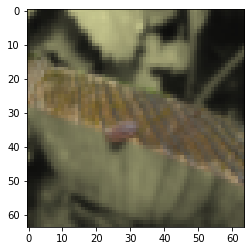

In [5]:
# Exemplo
index = 12
plt.imshow(treino_x_orig[index])
print ("y = " + str(treino_y[:, index]) + ", it's a '" + classes[np.squeeze(treino_y[:, index])].decode("utf-8") +  "' picture.")

**Exercício:** Encontre os valores para: (0,5pt)
     





*   m_treino (número de exemplos de treinamento)
*   m_teste (número de exemplos de teste)
* num_px (altura = largura de uma imagem de treinamento)


dica: você tems estes valores nas dimensões dos tensores treino_x_orig e treino_y_orig




In [6]:
### Início do código ### (≈ 3 linhas)
#ToDo : implemente o bloco
m_treino = 209 # ToDo
m_teste = 50 # ToDo
num_px = 64 # ToDo
### Fim do código ###

print ("Número de exemplos de treinamento: m_treino = " + str(m_treino))
print ("Número de exemplos de teste: m_teste = " + str(m_teste))
print ("Altura/largura de cada imagem: num_px = " + str(num_px))
print ("Tamanho de cada imagem: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("formto de treino_x: " + str(treino_x_orig.shape))
print ("formto de treiro_y: " + str(treino_y.shape))
print ("formto de teste_x: " + str(teste_x_orig.shape))
print ("formto de teste_y: " + str(teste_y.shape))

Número de exemplos de treinamento: m_treino = 209
Número de exemplos de teste: m_teste = 50
Altura/largura de cada imagem: num_px = 64
Tamanho de cada imagem: (64, 64, 3)
formto de treino_x: (209, 64, 64, 3)
formto de treiro_y: (1, 209)
formto de teste_x: (50, 64, 64, 3)
formto de teste_y: (1, 50)


**Valores esperados para m_treino, m_teste and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_treino**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_teste**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>

# 3 - Pré-processamento

## 3.1 - Formatação (0,5pt)
Por conveniência, vamos **"vetorizar"** as imagens para que elas fiquem nas dimensões: (num_px $ * $ num_px $ * $ 3, 1). Depois disso, nosso conjunto de dados de treinamento (e teste) será uma matriz ndarray(numpy) em que cada coluna representa uma imagem vetorizada. Deve haver m_treino colunas. O memso para o conjunto de teste (m_teste colunas)

**Exercício:** Formate os conjuntos de dados de treinamento e teste para que as imagens de tamanho (num_px, num_px, 3) sejam vetores de forma (num_px $ * $ num_px $ * $ 3, 1).

dica: ver documentação da função reshape(..)

In [7]:
# Formate o conjunto de treinamento e teste 

### Início do código ### (≈ 2 linhas)
#ToDo : implemente o bloco
treino_x_vet = np.reshape(treino_x_orig , (m_treino * num_px * num_px * 3, 1)) # ToDo
teste_x_vet = np.reshape(teste_x_orig , (m_teste * num_px * num_px * 3, 1)) # ToDo
### Fim do código ###

print ("Formato de treino_x_vet: " + str(treino_x_vet.shape))
print ("Formato de treino_y: " + str(treino_y.shape))
print ("Formato de teste_x_vet: " + str(teste_x_vet.shape))
print ("Formato de teste_y: " + str(teste_y.shape))


Formato de treino_x_vet: (2568192, 1)
Formato de treino_y: (1, 209)
Formato de teste_x_vet: (614400, 1)
Formato de teste_y: (1, 50)


## 3.2 -  Normalização (0,5pt)

As imagens do conjunto de dados são repreesentadas por canais (RGB). Os canais vermelho, verde e azul devem ser especificados para cada pixel e, portanto, o valor do pixel é na verdade um vetor de três números que podem variar de 0 a 255.

Uma etapa comum de pré-processamento no aprendizado de máquina é centralizar e normalizar seu conjunto de dados, que significa subtrair cada exemplo pela média e dividir pelo desvio padrão de toda a matriz (de dados de treino ou de teste). Porém, para conjuntos de dados de imagens, é mais simples e conveniente e funciona muito bem apenas dividir todas as linhas do conjunto de dados por 255 (o valor máximo).

Vamos normalizar o conjunto de dados, dexando os valores dos pixels entre 0 e 1.

In [8]:
# Normaliza os dados

#ToDo : implemente o bloco
treino_x = treino_x_vet / 255.0 # ToDo
teste_x = teste_x_vet / 255.0 # ToDo


## 4 - Arquitetura geral do algoritmo de aprendizado ##

A figura a seguir explica por que **a regressão logística é realmente uma rede neural muito simples!**

![Arq,widht=200](https://drive.google.com/uc?export=view&id=16lfjW5R0BMWrGMLY2j3pRvQ_16ttDJRe)


**Expressão matemática do algoritmo**:

Para um exemplo $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

O custo é então calculado somando sobre todos os exemplos do treinamento:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Etapas principais**:

Neste exercício, você executará as seguintes etapas:

     - Inicializar os parâmetros do modelo
     - Aprender os parâmetros do modelo, minimizando o custo
     - Use os parâmetros aprendidos para fazer a predição (no conjunto de testes)
     - Analisar os resultados.

### 4.1 - Funções auxiliares (1pt)

**Exercício**: Implemente a função de ativação `sigmoid ()`. Como você viu na figura acima, você precisa calcular  $sigmoid (w^T x + b) = \frac {1} {1 + e^{- (w^T x + b)}}$ para fazer previsões.

dica: você pode usar a função exponencial do numpy (np.exp(-z))

In [9]:
# Função de ativação sigmoid

def sigmoid(z):
    """
    Calcula a sigmoid de z

    entrada:
    z -- Um escalar ou um numpy array de qualquer tamanho.

    saída:
    s -- sigmoid(z)
    """

    ### Início do código ### (≈ 1 linha)
    #ToDo : implemente o bloco
    s = 1/(1+np.exp(-z)) # ToDo
    ### Fim do código ###
    
    return s

In [10]:
# Teste
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Valor esperado**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Inicializando Parâmetros (1pt)

**Exercício:** Implemente a inicialização dos parâmetros w e b. 

dica: veja função  np.zeros(..)

In [11]:
# Função: inicializa w e b

def inicialize(dim):
    """
    Inicializa um vetor de tamanho (dim, 1) para w and  b = 0.
    
    Entrada:
    dim -- tamanho de w (número de parâmetros)
    
    Saída:
    w -- tamanho (dim, 1)
    b -- um escalar (correspondente ao bias)
    """
    
    ### Início do código ### (≈ 1 line of code)
    #ToDo : implemente o bloco
    w = np.zeros((dim,1)) # ToDo
    b = 0 # ToDo
    ### Fim do código ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [12]:
# Teste

dim = 2
w, b = inicialize(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Valores esperados**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>


### 4.3 - Forward and Backward propagation (2pt)

**Exercício:** Implemente a função `propagacao ()` que calcula a função de custo e seu gradiente.


**Forward-Propagation:**
- Entrada X
- Calcule a ativação $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calcule a função de custo: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

**Backward-propagation:**

Fórmulas do gradiente: 

$$\frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [13]:
# Forward and Backward propagation

def propagacao(w, b, X, Y):
    """
    Implementa a função custo e seus gradientes

    Entrada:
    w -- pesos, de tamanho (num_px * num_px * 3, 1)
    b -- bias, um escalar
    X -- dados de treinamentos de tamanho (num_px * num_px * 3, número de exemplos)
    Y -- ( 0 se não-gato, 1 se gato) de tamanho (1, número de exemplos)

    Saída:
    custo -- custo para regressão logística
    dw -- gradiente da função loss em relação a w
    db -- gradiente da função loss em relação a b
    

    """

    #ToDo : implemente a função
    Y = np.array(Y) # converte para o tipo ndarray para acessar o .shape do objeto
    m = (Y.size) # número de exemplos
    # FORWARD PROPAGATION 
    ### Início do código ### (≈ 4 a 5 linhas)
    #ToDo : implemente o bloco
    w = np.array(w)
    X = np.array(X)
    A = sigmoid(np.dot(np.transpose(w),X)+b) # calcula ativação, dica use sua função sigmoid
    custo = sum(-1/m *((Y * (np.log(A))) + ( (1 - Y) * (np.log(1-A)))) ) # calcula custo. Dica : use np.log(..)
    custo = sum(custo)
    ### Fim do código ###
    
    # BACKWARD PROPAGATION
    ### Início do código ### (≈ 2 linhas)
    #ToDo : implemente o bloco
    dw = (1/m * (np.dot(X, np.transpose(A-Y)) ))  # dica: use np.dot(..) e não esqueça que em algumas operações um dos vetores precisa ser transposto
    db = sum(sum(1/m * (A-Y)))
    ### Fim do código ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    custo = np.squeeze(custo)
    assert(custo.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, custo

In [14]:
# Teste
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, custo = propagacao(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("custo = " + str(custo))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
custo = 5.8015453193945525


**Valores esperado**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** custo **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Otimização (2pt)
- O processo de atualização dos parâmetros é realizado pelo algoritmo da descida do gradiente.

**Exercício:** Atualize $w$ e $b$, minimizando a função de custo $J$. Para um parâmetro $ \theta $, a regra de atualização é $\theta = \theta - \alpha \text{ } d\theta$, em que $\alpha$ é a taxa de aprendizado.

In [15]:
# Algoritmo da descida do gradiente
def softmax(x):
    
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def gradiente_descendente(w, b, X, Y, num_iter, learning_rate, print_custo = False):
    """
    Esta função atualiza/otimiza os parâmetros w e b através do algoritmo do graidente
    
    Entrada:
    w -- pesos, de tamanho (num_px * num_px * 3, 1)
    b -- bias, um escalar
    X -- dados de treinamentos de tamanho (num_px * num_px * 3, número de exemplos)
    Y -- ( 0 se não-gato, 1 se gato) de tamanho (1, número de exemplos)
    num_iter -- número de interações
    learning_rate -- taxa de aprendizegem do algoritmo gradiente descendente
    print_custo -- print flag
    
    Saída:
    params -- dictionário contendo os pesos w e bias b
    grads -- dictionário contendo os gradientes dos pesos w e bias b com relação a função custo
    custos -- lista de todos os custos durante a otimização, será usado para plotar a curva de aprendizado.
    
    
    """
    
    custos = []
    
    for i in range(num_iter):
        
        
        # Calcula o custo e os gradientes (≈ 1-4 linhas)
        ### Início do código ### 
        #ToDo : implemente o bloco
        #grads = np.softmax(custo)
        #custo = sigmoid(grads)
        #custo = np.dot(np.transpose(w),X)+b
        m=np.size(Y)
        A = sigmoid(np.dot(np.transpose(w),X)+b)
        custo = -1/m * np.sum(((Y * (np.log(A))) + ( (1 - Y) * (np.log(1-A)))))
        #print(str(custo))
        #custo = sum(custo)
        #grads = sigmoid(custo) 
        #print(str(grads))
        # dica: use sua funcao propagacao(..)
        ### Fim do código ###
        
        # Recupera os gradientes do dicionário grads
        #ToDo : implemente o bloco
        #dw = (sigmoid(grads)*(1-sigmoid(grads)))  # dica: fique atento ao tipo de dados de grads para acessar os índices de "dw" e "db"
        #db = (sigmoid(grads)*(1-sigmoid(grads)))
        dw = (1/m * (np.dot(X, np.transpose(A-Y)) ))
        db = 1/m * np.sum(A-Y)
        #print(str(dw))
        
        # Atualiza w e b (≈ 2 linhas)
        ### Início do código ###
        #ToDo : implemente o bloco, lembrando sempre da taxa de aprendizagem (learning_rate)
        w -= dw*learning_rate
        b -= db*learning_rate
        ### Fim do código ###
        
        # Guarda custos
        if i % 100 == 0:
            custos.append(custo)
        
        # Imprime o custo a cada 100 interações
        if print_custo and i % 100 == 0:
            print (f"Custo após {i:4d} iterações: {custo:.4f}")
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, custos

In [16]:
# Teste
params, grads, custos = gradiente_descendente(w, b, X, Y, num_iter= 100, learning_rate = 0.009, print_custo = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Valores esperados**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591] [ 0.12259159]] </td>
    </tr>
    
  <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    
   <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042][ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>

</table>

### 4.5 - Predição (2pt)

- Depois do aprendizado dos parâmentros w e b, eles são usados para predizer os rótulos para um conjunto de dados X.

**Exercício:**. Implemente a função `predicao ()`:

1. Calcule $ \hat{Y} = A = \sigma(w^T X + b) $

2. Converta $ \hat{Y}$ em 0 (se ativação <= 0,5) ou 1 (se ativação > 0,5).

In [17]:
# GRADED FUNCTION: predição

def predicao(w, b, X):
    '''
    Prediz se o rótulo é 0 ou 1 usando os parâmetros de aprendizagem (w,b) da regressão logística
    
    Entrada:
    w -- pesos, de tamanho (num_px * num_px * 3, 1)
    b -- bias, um escalar
    X -- dados de treinamentos de tamanho (num_px * num_px * 3, número de exemplos)
    
    Saída:
    Y_pred -- um vetor contendo todas as predições (0/1) para os dados X
    '''
    
    #ToDo : implemente a função

    m = int(X.size/w.size)       # número de exemplos. Dica: acesso o shape de X e veja qual valor adequado
    Y_pred = np.zeros((1,m))  # inicialize o vetor de predições. dica: ver  np.zeros()
    print(str(Y_pred))
    
    # Calcule o vetor "A" da probabilidade de um gato estar na imagem
    ### Início do código ### (≈ 1 lnha)
    #ToDo : implemente o bloco
    A = sigmoid(np.dot(np.transpose(w),X)+b)  # dica: mesma ideia da função propagacao(..)
    A = sum(A)
    print(str(A))
    ### Fim do código ###
    
    # Converta as proobabilidades A[0,i] para predição p[0,i]
    ### Início do código ### (≈ 1 a 4 linhas)
    #ToDo : implemente o bloco    
    # dica: considere, no vetor A, valores maiores ou iguais a 0.5 como classe 1 e menores que 0.5 como classe 0
    # e coloque o resultado no vetor Y_pred

    for i in range(m):
      if A[i]>=0.5:
        Y_pred[0,i] = 1
     
          
    ### Fim do código ###       
        
    
    assert(Y_pred.shape == (1, m))
    
    return Y_pred

In [18]:
# Teste
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predições = " + str(predicao(w, b, X)))

[[0. 0. 0.]]
[0.52241976 0.50960677 0.34597965]
predições = [[1. 1. 0.]]


**Valor esperado**: 

<table style="width:30%">
    <tr>
         <td>
             **predições**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>

## 5 - Construa o modelo com as funções anteriores


**Exercício:** Construa um modelo. Use a seguinte notação:

     - Y_pred_teste para suas previsões no conjunto de testes
     - Y_pred_treino para suas previsões no treino
     - w, custos, grads para as saídas do algoritmo `gradiente()`.

In [19]:
# Modelo

def modelo(X_treino, Y_treino, X_teste, Y_teste, num_iter = 5000, learning_rate = 0.5, print_custo = False):
    """
    Cria o modelo de regressão logística chamando as funções auxiliares
    
    Entradas:
    X_treino -- conjunto de treinamento representado por uma matriz numpy da forma (num_px * num_px * 3, m_treino)
    Y_treino -- rótulos de treinamento representados por uma matriz numpy (vetor) da forma (1, m_treino)
    X_teste -- conjunto de teste representado por uma matriz numpy da forma (num_px * num_px * 3, m_teste)
    Y_teste -- rótulos de teste representados por uma matriz numpy (vetor) da forma (1, m_teste)
    num_iter -- hiperparâmetro que representa o número de iterações para otimizar os parâmetros
    learning_rate -- hiperparâmetro que representa a taxa de aprendizado usada na regra de atualização do gradiente descendete
    print_custo -- Defina como true para imprimir o custo a cada 100 iterações
    
    Saída:
    d -- dicionário contendo informações sobre o modelo.
    """
    
    ### Início do código ###
    #ToDo : implemente a função e complete os blocos abaixo
    
    # iniciliza os parâmetros (≈ 1 linha). Use sua funcao de inicialização e coloque o retorno em w e b
    dim=X_treino.shape[0]
    w, b = inicialize(dim)
    #print(str(w))
    # Gradiente descendente (≈ 1 linha). Use sua função  gradiente_descendente e preencha as variáveis de retorno
    #grads,custo = propagacao(w, b, X_treino, Y_treino)

    #w=grads["dw"]
    #b=grads["db"]
    
    parametros, grads, custos = gradiente_descendente(w, b, X_treino, Y_treino, num_iter, learning_rate, print_custo)
    
    # Recupere os parâmetros w e b do dicionário "parametros"
    w = parametros["w"]
    b = parametros["b"]
    #print(str(w.shape))
    
    # Compute predicoes para os conjuntos treino e teste (≈ 2 linhas). Use sua função predicao(..)
    Y_pred_teste = predicao(w, b, X_teste)
    Y_pred_treino = predicao(w, b, X_treino)

    ### Fim do código ###

    # Imprime erros do treino/teste 
    print("treino acurácia: {} %".format(100 - np.mean(np.abs(Y_pred_treino - Y_treino)) * 100))
    print("teste acurácia: {} %".format(100 - np.mean(np.abs(Y_pred_teste - Y_teste)) * 100))

    
    d = {"custos": custos,
         "Y_pred_teste": Y_pred_teste, 
         "Y_pred_treino" : Y_pred_treino, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iter": num_iter}
    
    return d

## 6 - Execute o modelo

Execute a célula a seguir para treinar seu modelo.

In [20]:
d = modelo(treino_x, treino_y, teste_x, teste_y, num_iter = 3000, learning_rate = 0.01, print_custo = True)

ValueError: ignored

**Valores esperados**: 

<table style="width:40%"> 

   <tr>
        <td> **Custo depois da iteração 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Acurácia no treino**  </td> 
        <td> 100 % </td>
    </tr>

   <tr>
        <td>**Acurácia no teste** </td> 
        <td> 68.0 % </td>
    </tr>
</table> 


**Responda** (0,5pt): A acurácia no treinamento é próxima de 100%. Seu modelo está funcionando e tem capacidade alta o suficiente para ajustar os dados de treinamento. A acurácia no teste é de 68%. Porque tanta diferença?

In [21]:
# Exemplos das predições
index = 11
plt.imshow(teste_x[:,index].reshape((num_px, num_px, 3)))
print (f'y = {classes[teste_y[0,index]].decode("utf-8")}({teste_y[0,index]}), o modelo predizeu que é um "{classes[int(d["Y_pred_teste"][0][index])].decode("utf-8")}" picture.')

IndexError: ignored

 Plota a função custo e os gradientes

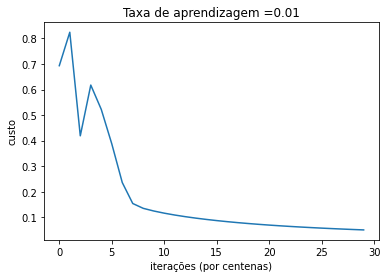

In [ ]:
# Plot learning curve (with costs)
custos = np.squeeze(d['custos'])
plt.plot(custos)
plt.ylabel('custo')
plt.xlabel('iterações (por centenas)')
plt.title("Taxa de aprendizagem =" + str(d["learning_rate"]))
plt.show()

**Interpretação**:
Você pode ver o custo diminuindo. Isso mostra que os parâmetros estão sendo aprendidos. No entanto, você pode treinar o modelo ainda mais no conjunto de treinamento. Tente aumentar o número de iterações e execute novamente. O que acontece?

ToDo : discorra sobre a pergunta.

## 6 - Mais análises  ##


#### Escolha da Taxa de aprendizagem ####

**Lembrete**:
O algoritmo da descida do gradiente, depende da escolha da taxa de aprendizado. A taxa de aprendizado $ \alpha $ determina a rapidez com que atualizamos os parâmetros. Se a taxa de aprendizado for muito alta, podemos "ultrapassar" o valor ideal. Da mesma forma, se for muito pequeno, precisaremos de muitas iterações para convergir para os melhores valores. É por isso que é crucial usar uma taxa de aprendizado bem ajustada.

Vamos comparar a curva de aprendizado do modelo com várias opções de taxas de aprendizado. Execute a célula abaixo. 

learning rate is: 0.025
treino acurácia: 100.0 %
teste acurácia: 68.0 %

-------------------------------------------------------

learning rate is: 0.0025
treino acurácia: 97.12918660287082 %
teste acurácia: 70.0 %

-------------------------------------------------------

learning rate is: 0.0001
treino acurácia: 72.2488038277512 %
teste acurácia: 42.00000000000001 %

-------------------------------------------------------



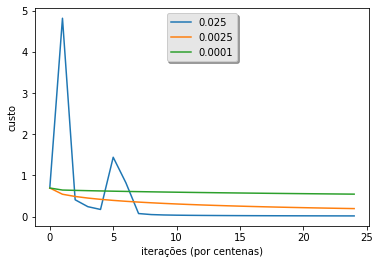

In [ ]:
learning_rates = [0.025, 0.0025, 0.0001]
modelos = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    modelos[str(i)] = modelo(treino_x, treino_y, teste_x, teste_y, num_iter = 2500, learning_rate = i, print_custo = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(modelos[str(i)]["custos"]), label= str(modelos[str(i)]["learning_rate"]))

plt.ylabel('custo')
plt.xlabel('iterações (por centenas)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretação**:
- Diferentes taxas de aprendizado fornecem custos diferentes e, portanto, resultados de previsões diferentes.
- Se a taxa de aprendizado for muito alta (0,01), o custo poderá oscilar para cima e para baixo. Pode até divergir (embora, neste exemplo, o uso de 0,01 ainda termine com um bom valor para o custo).
- Um custo menor não significa um modelo melhor. Pode ocorrer o `overfitting`. Isso acontece quando a precisão do treinamento é muito maior que a precisão do teste.


# **Atividade Complementar 1**
Use seu modelo de regressão logistica para o seguinte dataset.

Conjunto de dados de 2 classes com entradas X e rótulos (Y=0, vermelho) e (Y=1, azul). Seu objetivo é verificar se seu classificador se ajusta a esses dados. Em outras palavras, o classificador defina as regiões de vermelha ou azul.

In [ ]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [ ]:
X, Y = load_planar_dataset()

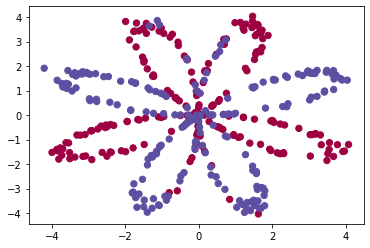

In [ ]:
# Visualize os dados
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

In [ ]:
# ToDo: plote a fronteira de decisão do seu modelo!


# **Atividade Complementar 2**

Repita o problema de classificação de gatos usando um objeto da biblioteca [scikit-learn](https://scikit-learn.org/stable/index.html) que implementa o classificador de vizinhos mais próximos (Nearest Neighbors Classification - [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)). O KNN é um classificador baseado em instâncias e o parâmetro K define o número de vizinhos a se considerar durante a classificação. Ajuste este parâmetro de forma empírica e compare com os resultados obtidos com a regressão logística.

In [ ]:
from sklearn import neighbors

#ToDo : repita usando-se o KNN do sklearn